In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
train_images = np.load("./augmented_data_20/images_train.npy")
train_labels = np.load("./augmented_data_20/labels_train.npy")

train_images = train_images[..., np.newaxis]
train_labels = train_labels[..., np.newaxis]

U_net = tf.keras.models.load_model('U_net_v02_geo_sparse')

file_path = "U-net_v02_geo_sparse.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [3]:
print("Original label shape: %s" % (train_labels.shape,))

Original label shape: (13472, 256, 256, 1)


## Convert the labels to categorical vectors - one hot encoded

In [4]:
num_class = 3
train_labels = train_labels[:,:,:,0] if(len(train_labels.shape) == 4) else train_labels[:,:,0]    
new_train_labels = np.reshape(train_labels, [train_labels.shape[0], train_labels.shape[1]*train_labels.shape[2]])
#new_train_labels = to_categorical(new_train_labels, num_classes=num_class, dtype='uint8')
train_labels = new_train_labels

In [5]:
print("Vectorized new label shape: %s" % (train_labels.shape,))

Vectorized new label shape: (13472, 65536)


## Fit the U_net_v02_geo 

In [8]:
history = U_net.fit(train_images, train_labels, epochs= 5, validation_split=0.2, verbose=1, callbacks=callbacks_list)

U_net.save_weights("U_net_v02_geo_sparse.h5")

Train on 10777 samples, validate on 2695 samples
Epoch 1/5
10777/10777 [==============================] - 3195s 296ms/sample - loss: 0.1595 - accuracy: 0.9438 - val_loss: 0.4366 - val_accuracy: 0.7912
Epoch 2/5


C:\Users\geors\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


10777/10777 [==============================] - 3201s 297ms/sample - loss: 0.1160 - accuracy: 0.9561 - val_loss: 0.1764 - val_accuracy: 0.9348
Epoch 3/5
10777/10777 [==============================] - 3936s 365ms/sample - loss: 0.0961 - accuracy: 0.9621 - val_loss: 0.0891 - val_accuracy: 0.9655
Epoch 4/5
10777/10777 [==============================] - 4358s 404ms/sample - loss: 0.0844 - accuracy: 0.9679 - val_loss: 0.1085 - val_accuracy: 0.9620
Epoch 5/5
10777/10777 [==============================] - 4031s 374ms/sample - loss: 0.0762 - accuracy: 0.9716 - val_loss: 0.0982 - val_accuracy: 0.9616


## Get predicted labels

In [9]:
images_test = np.load("./augmented_data_20/images_test.npy")
images_test = images_test[..., np.newaxis]

In [10]:
U_net.load_weights("U_net_v02_geo_sparse.h5")
labels_test_pred = U_net.predict(images_test)

In [11]:
np.save("./augmented_data_20/labels_test_pred_sparse", labels_test_pred)

## Evaluate the U-net

In [12]:
labels_test_pred = np.load("./augmented_data_20/labels_test_pred_sparse.npy")

In [13]:
labels_test = np.load("./augmented_data_20/labels_test.npy")
labels_test = labels_test#[..., np.newaxis]
print("Shape of test labels: %s \nShape of predicted labels: %s" % (labels_test.shape, labels_test_pred.shape))
new_labels_test = np.reshape(labels_test, [labels_test.shape[0], labels_test.shape[1]*labels_test.shape[2]])
print("New test labels shape: %s " % (new_labels_test.shape,))

Shape of test labels: (3368, 256, 256) 
Shape of predicted labels: (3368, 65536, 3)
New test labels shape: (3368, 65536) 


In [14]:
labels_test_pred[0][0]

array([0.98468864, 0.01261205, 0.00269927], dtype=float32)

In [15]:
labels_test_pred = np.argmax(labels_test_pred, axis=-1)
print("New predicted labels shape: %s " % (labels_test_pred.shape,))

New predicted labels shape: (3368, 65536) 


In [16]:
def get_scores(y_true, y_pred):
    results=[]
    y_true=y_true.flatten()
    y_pred=y_pred.flatten()
    #Overall precision
    results.append(metrics.precision_score(y_true, y_pred, average='micro'))
    #Per-class precision
    results.append(metrics.precision_score(y_true, y_pred, average='macro'))
    #jaccard (right average?)
    results.append(metrics.jaccard_score(y_true, y_pred, average='macro'))
    return results
get_scores(new_labels_test, labels_test_pred)

[0.9621001173368259, 0.8736158541435554, 0.5541348917235247]

## Plot outcome

In [17]:
# reshape back to original dimensions
labels_test_pred_org = np.reshape(labels_test_pred, [labels_test_pred.shape[0], 256, 256])
labels_test_pred_org.shape

(3368, 256, 256)

In [18]:
np.unique(labels_test_pred_org)

array([0, 1, 2], dtype=int64)

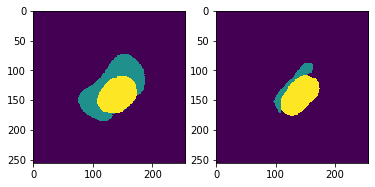

In [19]:
ind = 2
plt.subplot(1,2,1)
plt.imshow(labels_test[ind])
plt.subplot(1,2,2)
plt.imshow(labels_test_pred_org[ind])

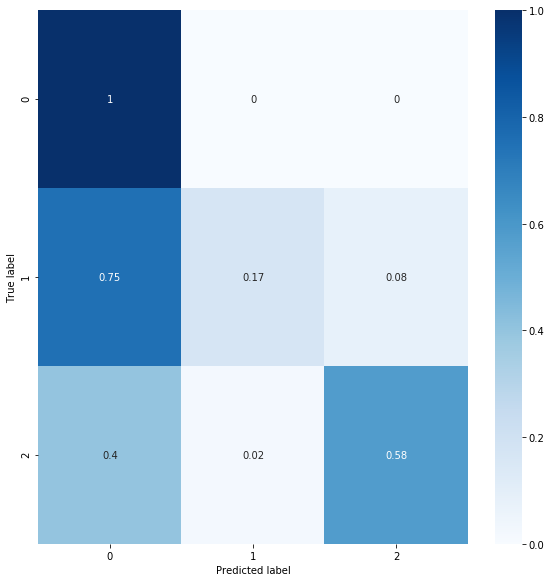

In [20]:
classes=[0,1,2]

con_mat = tf.math.confusion_matrix(labels=new_labels_test.flatten(), predictions=labels_test_pred.flatten()).numpy()

# Normalization of Confusion Matrix to the interpretation of which class is being misclassified.
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)

# plot confusion matrix
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()